In [5]:
import pandas as pd
import numpy as np
import copy
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [6]:
# This uses a simpler policy than the versions 2 or 3, a 3, 3, 3, 3, 3, 3 policy
# This trains just the cat. 

In [7]:
# Constants set to vary how the game is played
# These have to be at least 5 in order for the policies to be well-formed.

NUM_ROWS = 5
NUM_COLS = 5
FIRST_MOVE = "mouse"
ANIMATION_TIME_PER_MOVE = 0.1

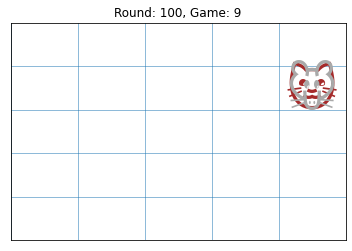

Iteration:    110, Number of wins: 1000, avg. number of moves until a win: 6.899, avg_distance: 2.128376388888889
Iteration:    120, Number of wins: 1000, avg. number of moves until a win: 6.899, avg_distance: 2.128376388888889
Iteration:    130, Number of wins: 1000, avg. number of moves until a win: 6.899, avg_distance: 2.128376388888889
Iteration:    139, Number of wins: 1000, avg. number of moves until a win: 6.885, avg_distance: 2.1294284920634925
Iteration:    140, Number of wins: 1000, avg. number of moves until a win: 6.885, avg_distance: 2.1294284920634925
Iteration:    150, Number of wins: 1000, avg. number of moves until a win: 6.885, avg_distance: 2.1294284920634925
Iteration:    160, Number of wins: 1000, avg. number of moves until a win: 6.885, avg_distance: 2.1294284920634925
Iteration:    170, Number of wins: 1000, avg. number of moves until a win: 6.885, avg_distance: 2.1294284920634925
Iteration:    180, Number of wins: 1000, avg. number of moves until a win: 6.885, a

In [8]:
def init_board():
    # The cat starts in the bottom-left corner; the mouse in the upper-right.
    # The y values start with 0 at the bottom, with the top row being NUM_ROWS-1
    board = {'cat_x': 0,
             'cat_y': 0,
             'mouse_x': NUM_COLS-1,
             'mouse_y': NUM_ROWS-1}
    return board


def draw_board(board, animation_title, game_num):
    clear_output(wait=True)
    s = sns.scatterplot(x=[], y=[])
    for i in range(NUM_ROWS):
        s.axhline(i, linewidth=0.5)
    for i in range(NUM_COLS):
        s.axvline(i, linewidth=0.5)
    s.set_xlim(0, NUM_COLS)
    s.set_ylim(0, NUM_ROWS)
    offset = 0.1
    size = 250 / max(NUM_ROWS, NUM_COLS)
    plt.text(board['cat_x'] + offset, board['cat_y'] + offset, '🐱', size=size, color='brown')
    plt.text(board['mouse_x'] + offset, board['mouse_y'] + offset, '🐭', size=size, color='darkgray')
    s.set_xticks([])
    s.set_yticks([])
    plt.title(f"Round: {animation_title}, Game: {game_num}")
    plt.show()
    time.sleep(ANIMATION_TIME_PER_MOVE)

'''
is_left_edge:
    0: no edge on either side
    1: edge on the left side of the 3x3
    2: edge on the right side of the 3x3

is_top_bottom_edge:
    0: no edge on either side
    1: edge on the bottom of the 3x3
    2: edge on the top of the 3x3

'''

def is_valid_policy(cat_x, cat_y, mouse_x, mouse_y,
                    is_left_right_edge, is_top_bottom_edge,
                    direction, curr_player):
    assert cat_x in [0, 1, 2]
    assert cat_y in [0, 1, 2]
    assert mouse_x in [0, 1, 2]
    assert mouse_y in [0, 1, 2]
    assert is_left_right_edge in [0, 1, 2]
    assert is_top_bottom_edge in [0, 1, 2]

    if curr_player == 'cat':
        if (cat_x == 0) and (is_left_right_edge == 1) and (direction == 'L'):
            return False
        if (cat_x == 2) and (is_left_right_edge == 2) and (direction == 'R'):
            return False
        if (cat_y == 0) and (is_top_bottom_edge == 1) and (direction == 'D'):
            return False
        if (cat_y == 2) and (is_top_bottom_edge == 2) and (direction == 'U'):
            return False
        return True
    else:
        if (mouse_x == 0) and (is_left_right_edge == 1) and (direction == 'L'):
            return False
        if (mouse_x == 2) and (is_left_right_edge == 2) and (direction == 'R'):
            return False
        if (mouse_y == 0) and (is_top_bottom_edge == 1) and (direction == 'D'):
            return False
        if (mouse_y == 2) and (is_top_bottom_edge == 2) and (direction == 'U'):
            return False
        return True


def set_initial_policy(curr_player):
    """
    Both players are initially set to move up unless this is impossible, in which case they move
    down. The policy applies only when both players are within a 3x3 grid.
    """
    policy = np.zeros([3, 3, 3, 3, 3, 3]).tolist()
    for cat_x in range(3):
        for cat_y in range(3):
            for mouse_x in range(3):
                for mouse_y in range(3):
                    for is_left_right_edge in range(3):
                        for is_top_bottom_edge in range(3):
                            for direction in ['U', 'D', 'L', 'R']:
                                if is_valid_policy(cat_x, cat_y, mouse_x, mouse_y,
                                                   is_left_right_edge, is_top_bottom_edge,
                                                   direction, curr_player):
                                    policy[cat_x][cat_y][mouse_x][mouse_y][is_left_right_edge][is_top_bottom_edge] = direction
                                    break
    return policy


def execute(cat_policy, mouse_smart, round_idx, policy_idx, draw_execution=False, animation_title=None):

    def check_winner(board, move_num):
        if move_num >= ((NUM_ROWS + NUM_COLS) * 2):
            return 'mouse'
        if (board['cat_x'] == board['mouse_x']) and (board['cat_y'] == board['mouse_y']):
            return 'cat'
        return None


    def get_local_board(board):
        """
        Return a 3x3 board representing the local space if both players are close enough
        to each other to fit in a 3x3 space. Adjust this to the edge of the full board
        if possible.
        """
        local_board = {}

        dist_x = abs(board['cat_x'] - board['mouse_x'])
        at_left = min(board['cat_x'], board['mouse_x']) == 0
        one_from_left = min(board['cat_x'],  board['mouse_x']) == 1

        # Put the right-most player in the right column of the 3x3 grid
        if board['cat_x'] > board['mouse_x']:
            local_board['cat_x'] = 2
            local_board['mouse_x'] = (2 - dist_x)
        else:
            local_board['cat_x'] = (2 - dist_x)
            local_board['mouse_x'] = 2

        # Adjust to put at the edge if necessary
        if at_left:
            if dist_x == 0:
                local_board['cat_x'] = 0
                local_board['mouse_x'] = 0
            elif board['cat_x'] > board['mouse_x']:
                local_board['cat_x'] = dist_x
                local_board['mouse_x'] = 0
            else:
                local_board['cat_x'] = 0
                local_board['mouse_x'] = dist_x
        if one_from_left:
            if dist_x == 0:
                local_board['cat_x'] = 1
                local_board['mouse_x'] = 1
            if dist_x == 1:
                if board['cat_x'] > board['mouse_x']:
                    local_board['cat_x'] = 2
                    local_board['mouse_x'] = 1
                else:
                    local_board['cat_x'] = 1
                    local_board['mouse_x'] = 2

        dist_y = abs(board['cat_y'] - board['mouse_y'])
        at_bottom = min(board['cat_y'],  board['mouse_y']) == 0
        one_from_bottom = min(board['cat_y'], board['mouse_y']) == 1

        # Put the top player in the top row of the 3x3 grid
        if board['cat_y'] > board['mouse_y']:
            local_board['cat_y'] = 2
            local_board['mouse_y'] = (2 - dist_y)
        else:
            local_board['cat_y'] = (2 - dist_y)
            local_board['mouse_y'] = 2

        # Adjust to put at the edge if necessary
        if at_bottom:
            if dist_y == 0:
                local_board['cat_y'] = 0
                local_board['mouse_y'] = 0
            elif board['cat_y'] > board['mouse_y']:
                local_board['cat_y'] = dist_y
                local_board['mouse_y'] = 0
            else:
                local_board['cat_y'] = 0
                local_board['mouse_y'] = dist_y
        if one_from_bottom:
            if dist_y == 0:
                local_board['cat_y'] = 1
                local_board['mouse_y'] = 1
            if dist_y == 1:
                if board['cat_y'] > board['mouse_y']:
                    local_board['cat_y'] = 2
                    local_board['mouse_y'] = 1
                else:
                    local_board['cat_y'] = 1
                    local_board['mouse_y'] = 2

        return local_board


    def get_left_right_edge(board):
        '''
        Returns: 0, 1, or 2 as defined above
        '''
        min_x = min(board['cat_x'], board['mouse_x'])
        max_x = max(board['cat_x'], board['mouse_x'])
        if min_x == 0:
            return 1
        if max_x == (NUM_COLS-1):
            return 2
        return 0


    def get_top_bottom_edge(board):
        '''
        Returns: 0, 1, or 2 as defined above
        '''
        min_y = min(board['cat_y'], board['mouse_y'])
        max_y = max(board['cat_y'], board['mouse_y'])
        if min_y == 0:
            return 1
        if max_y == (NUM_ROWS-1):
            return 2
        return 0


    def move_cat(board, cat_policy):
        if (abs(board['cat_x'] - board['mouse_x']) < 3) and (abs(board['cat_y'] - board['mouse_y']) < 3):
            local_board = get_local_board(board)
            is_top_bottom_edge = get_top_bottom_edge(board)
            is_left_right_edge = get_left_right_edge(board)
            move = cat_policy[local_board['cat_x']] \
                [local_board['cat_y']] \
                [local_board['mouse_x']] \
                [local_board['mouse_y']] \
                [is_left_right_edge] \
                [is_top_bottom_edge]
            if move == 'L':
                board['cat_x'] -= 1
            elif move == 'R':
                board['cat_x'] += 1
            elif move == 'D':
                board['cat_y'] -= 1
            elif move == 'U':
                board['cat_y'] += 1
            else:
                assert "Invalid move type"
            return board
        else:
            dist_x = abs(board['cat_x'] - board['mouse_x'])
            dist_y = abs(board['cat_y'] - board['mouse_y'])
            if dist_x > dist_y:
                if board['cat_x'] > board['mouse_x']:
                    board['cat_x'] -= 1
                else:
                    board['cat_x'] += 1
            else:
                if board['cat_y'] > board['mouse_y']:
                    board['cat_y'] -= 1
                else:
                    board['cat_y'] += 1
        return board


    def move_mouse(board):
        def is_valid_board(b, attempt_count):
            # Check not moving to the cat's cell
            if (b['mouse_x'] == b['cat_x']) and (b['mouse_y'] == b['cat_y']):
                return False
            
            # Check not moving off the edge
            if b['mouse_x'] < 0:
                return False
            if b['mouse_x'] >= NUM_COLS:
                return False
            if b['mouse_y'] < 0:
                return False
            if b['mouse_y'] >= NUM_ROWS:
                return False
            
            # Check not moving adjacent to the cat unless necessary, though allow
            # this randomly on occasion
            if mouse_smart and (attempt_count < 4):
                if (abs(b['mouse_x'] - b['cat_x']) == 1) and (abs(b['mouse_y'] == b['cat_y'])):
                    return False
                if (abs(b['mouse_y'] - b['cat_y']) == 1) and (abs(b['mouse_x'] == b['cat_x'])):
                    return False

            return True

        def update_board(b, direction):
            if direction == 'L':
                b['mouse_x'] -= 1
            elif direction == 'R':
                b['mouse_x'] += 1
            elif direction == 'D':
                b['mouse_y'] -= 1
            elif direction == 'U':
                b['mouse_y'] += 1
            return b

        new_board = copy.deepcopy(board)
        direction = np.random.choice(['U', 'D', 'L', 'R'])
        new_board = update_board(new_board, direction)
        attempt_count = 0
        while not is_valid_board(new_board, attempt_count):
            new_board = copy.deepcopy(board)
            direction = np.random.choice(['U', 'D', 'L', 'R'])
            new_board = update_board(new_board, direction)
            attempt_count += 1
        return new_board


    def get_distance(board):
        return math.sqrt(math.pow((board['cat_x'] - board['mouse_x']), 2) + math.pow((board['cat_y'] - board['mouse_y']), 2))


    def play_game():
        np.random.seed(game_num)
        board = init_board()

        if FIRST_MOVE == 'cat':
            board = move_cat(board, cat_policy)

        # Execute for at most the possible number of unique board positions. After this, there must be a cycle if there
        # is no capture.
        distance_arr = []
        move_number = 0
        while True:
            move_number += 1

            # Move the mouse
            board = move_mouse(board)
            if draw_execution and (game_num < 10):
                draw_board(board, animation_title, game_num)
            winner = check_winner(board, move_number)
            if winner:
                return winner, move_number, np.mean(distance_arr)

            # Move the cat
            board = move_cat(board, cat_policy)
            assert 0 <= board['cat_x'] < NUM_COLS
            assert 0 <= board['cat_y'] < NUM_ROWS
            if draw_execution and (game_num < 10):
                draw_board(board, animation_title, game_num)
            winner = check_winner(board, move_number)
            distance_arr.append(round(get_distance(board), 2))
            if winner:
                return winner, move_number, sum(distance_arr) / move_number

    num_wins = 0
    num_moves_arr = []
    avg_distance_arr = []
    for game_num in range(1000):
        winner, num_moves, avg_distance = play_game()
        if winner == 'cat':
            num_wins += 1
            num_moves_arr.append(num_moves) # We just track the avg number of moves for wins, not for losses
        avg_distance_arr.append(avg_distance)
    return num_wins, np.mean(num_moves_arr), np.mean(avg_distance_arr)


def get_variations(policy, curr_player, round_idx, max_changes):
    np.random.seed(round_idx)
    num_new_policies = 10
    new_policies = []
    for _ in range(num_new_policies):
        p = copy.deepcopy(policy)
        num_changes = np.random.randint(1, max(1, max_changes)+1)
        for _ in range(num_changes):
            cat_x = np.random.randint(3)
            cat_y = np.random.randint(3)
            mouse_x = np.random.randint(3)
            mouse_y = np.random.randint(3)
            is_left_right_edge = np.random.randint(3)
            is_top_bottom_edge = np.random.randint(3)
            direction = np.random.choice(['R', 'L', 'U', 'D'])

            if not is_valid_policy(
                    cat_x, cat_y, mouse_x, mouse_y,
                    is_left_right_edge, is_top_bottom_edge,
                    direction, curr_player):
                continue

            p[cat_x][cat_y][mouse_x][mouse_y][is_left_right_edge][is_top_bottom_edge] = direction
        new_policies.append(p)
    return new_policies


np.random.seed(0)
cat_policy = set_initial_policy(curr_player='cat')
num_wins, avg_num_moves, avg_distance = execute(cat_policy, mouse_smart=False, round_idx=0, policy_idx=0, draw_execution=False, animation_title="Initial Policies")
prev_num_wins, prev_avg_num_moves, prev_avg_distance = num_wins, avg_num_moves, avg_distance
last_round_update_cat_policy = -1

round_idx = -1
while num_wins < 1000:
    round_idx += 1
    if (((round_idx % 10) == 0) and (round_idx > 0)) or \
            (prev_num_wins != num_wins) or (prev_avg_num_moves != avg_num_moves) or (prev_avg_distance != avg_distance):
        print((f"Iteration: {round_idx:>6,}, Number of wins: {num_wins:>3}, avg. number of moves until a win: {avg_num_moves:>2}, "
               f"avg_distance: {avg_distance}"))
        prev_num_wins, prev_avg_num_moves, prev_avg_distance = num_wins, avg_num_moves, avg_distance

    # Improve the cat every iteration
    best_p = copy.deepcopy(cat_policy)
    best_num_wins = num_wins
    best_avg_num_moves = avg_num_moves
    best_avg_distance = avg_distance
    num_rounds_since_change = round_idx - last_round_update_cat_policy 
    policy_variations = get_variations(cat_policy, curr_player='cat', round_idx=round_idx, max_changes=100-num_rounds_since_change)
    for p_idx, p in enumerate(policy_variations):
        p_num_wins, p_avg_num_moves, p_avg_distance = execute(p, mouse_smart=False, round_idx=round_idx, policy_idx=p_idx)
        if (p_num_wins > best_num_wins) or \
                ((p_num_wins == best_num_wins) and (p_avg_num_moves < best_avg_num_moves)) or \
                ((p_num_wins == best_num_wins) and (p_avg_num_moves == best_avg_num_moves) and (p_avg_distance < best_avg_distance)):
            best_p = copy.deepcopy(p)
            best_num_wins = p_num_wins
            best_avg_num_moves = p_avg_num_moves
            best_avg_distance = p_avg_distance

        if best_p != cat_policy:
            last_round_update_cat_policy = round_idx
            
    cat_policy = copy.deepcopy(best_p)
    num_wins = best_num_wins
    avg_num_moves = best_avg_num_moves
    avg_distance = best_avg_distance

    draw_execution = (round_idx % 20 == 0) and (round_idx > 0)  # set to 100!!!!!!!!!!
    if draw_execution:
        execute(cat_policy, mouse_smart=True, round_idx=round_idx, policy_idx=0, draw_execution=True, animation_title=round_idx)
        
num_wins, avg_num_moves, avg_distance = execute(cat_policy, mouse_smart=True, round_idx=0, policy_idx=0, draw_execution=False, animation_title="Initial Policies")
prev_num_wins, prev_avg_num_moves, prev_avg_distance = num_wins, avg_num_moves, avg_distance
last_round_update_cat_policy = 0
        
# todo: can simplify like version 5 to just start with a smarter mouse. Can just discuss
# making it simpler to start, but in this case makes progress well. 
for round_idx in range(200):
    if (((round_idx % 10) == 0) and (round_idx > 0)) or \
            (prev_num_wins != num_wins) or (prev_avg_num_moves != avg_num_moves) or (prev_avg_distance != avg_distance):
        print((f"Iteration: {round_idx:>6,}, Number of wins: {num_wins:>3}, avg. number of moves until a win: {avg_num_moves:>2}, "
               f"avg_distance: {avg_distance}"))
        prev_num_wins, prev_avg_num_moves, prev_avg_distance = num_wins, avg_num_moves, avg_distance

    # Improve the cat every iteration
    best_p = copy.deepcopy(cat_policy)
    best_num_wins = num_wins
    best_avg_num_moves = avg_num_moves
    best_avg_distance = avg_distance
    num_rounds_since_change = round_idx - last_round_update_cat_policy 
    policy_variations = get_variations(cat_policy, curr_player='cat', round_idx=round_idx, max_changes=100-num_rounds_since_change)
    for p_idx, p in enumerate(policy_variations):
        p_num_wins, p_avg_num_moves, p_avg_distance = execute(p, mouse_smart=True, round_idx=round_idx, policy_idx=p_idx)
        if (p_num_wins > best_num_wins) or \
                ((p_num_wins == best_num_wins) and (p_avg_num_moves < best_avg_num_moves)) or \
                ((p_num_wins == best_num_wins) and (p_avg_num_moves == best_avg_num_moves) and (p_avg_distance < best_avg_distance)):
            best_p = copy.deepcopy(p)
            best_num_wins = p_num_wins
            best_avg_num_moves = p_avg_num_moves
            best_avg_distance = p_avg_distance

        if best_p != cat_policy:
            last_round_update_cat_policy = round_idx
            
    cat_policy = copy.deepcopy(best_p)
    num_wins = best_num_wins
    avg_num_moves = best_avg_num_moves
    avg_distance = best_avg_distance

    draw_execution = (round_idx % 100 == 0) and (round_idx > 0)  
    if draw_execution:
        execute(cat_policy, mouse_smart=True, round_idx=round_idx, policy_idx=0, draw_execution=True, animation_title=round_idx)        

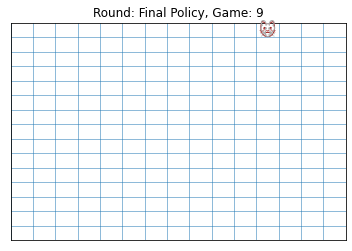

(1000, 26.546, 8.04781033031741)

In [9]:
# Test on a different sized board

NUM_ROWS = 15
NUM_COLS = 15
ANIMATION_TIME_PER_MOVE = 0.2
execute(cat_policy, mouse_smart=True, round_idx=0, policy_idx=0, draw_execution=True, animation_title="Final Policy")